# Name: Sai Sriharsha Griddaluru
## Email: sgridda@clemson.edu
## CUID: C15358926


# HW 1: TASK 2: Visualizing the Optimization process

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def nonlinear_sine_function(X):
    return np.sin(4*X)**2 + np.sin(8*X)

# generate X values
X = torch.linspace(-1,1,200).reshape(-1,1)

# calculate the corresponding Y values
Y = nonlinear_sine_function(X)

In [6]:
# calculating number of parameters in the MODEL
def calculate_num_of_parameters(model):
    val = sum(params.numel() for params in model.parameters() if params.requires_grad)
    return val
    

In [8]:
class Model(nn.Module):
    def __init__(self, in_features=1, h1=4, h2=8, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_features)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# instantiate the model
model = Model()

# print the model architecture
print(model)

# calculate the number of parameters in the model
model_params = calculate_num_of_parameters(model)

# print the total number of parameters
print(f"Number of Parameters:\n {model_params}\n")


Model(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
Number of Parameters:
 57



In [16]:
# Layer connection sizes
layer1_connections = 1 * 4
layer2_connections = 4 * 8
layer3_connections = 8 * 1

# Total connections in the model
total_model_connections = layer1_connections + layer2_connections + layer3_connections


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
num_iterations = 8
num_epochs = 30
interval = round(num_epochs / 3)
model_losses = []
counter = 0

layer2_weights_tensor = torch.zeros((num_iterations * interval, layer2_connections))
full_model_weights_tensor = torch.zeros((num_iterations * interval, total_model_connections))
losses_tensor = torch.zeros((num_iterations * interval, 1))

for iteration in range(num_iterations):
    model = Model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        y_pred = model(X)
        training_loss = criterion(y_pred, Y)
        model_losses.append(training_loss)

        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        if (epoch + 1) % 3 == 0:
            layer1_weights = torch.reshape(torch.flatten(model.fc1.weight), (1, layer1_connections))
            layer2_weights = torch.reshape(torch.flatten(model.fc2.weight), (1, layer2_connections))
            layer3_weights = torch.reshape(torch.flatten(model.fc3.weight), (1, layer3_connections))

            combined_weights = torch.cat((layer2_weights, layer1_weights), dim=1)
            full_model_weights = torch.cat((combined_weights, layer3_weights), dim=1)

            full_model_weights_tensor[counter] = full_model_weights
            layer2_weights_tensor[counter] = layer2_weights
            losses_tensor[counter] = training_loss

            counter += 1


In [20]:
def perform_pca(input_data, retained_dim):
    num_samples, num_features = input_data.shape
    feature_means = np.array([np.mean(input_data[:, i]) for i in range(num_features)])
    normalized_data = input_data - feature_means

    covariance_matrix = np.dot(normalized_data.T, normalized_data)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(num_features)]
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)
    
    selected_features = np.array([pair[1] for pair in eigen_pairs[:retained_dim]])
    reduced_data = np.dot(normalized_data, selected_features.T)
    
    return reduced_data


In [23]:
layer2_weights = layer2_weights_tensor.detach().cpu().numpy()
model_weights = full_model_weights_tensor.detach().cpu().numpy()
loss_values = losses_tensor.detach().cpu().numpy()

layer2_weights = perform_pca(layer2_weights, 2)
model_weights = perform_pca(model_weights, 2)

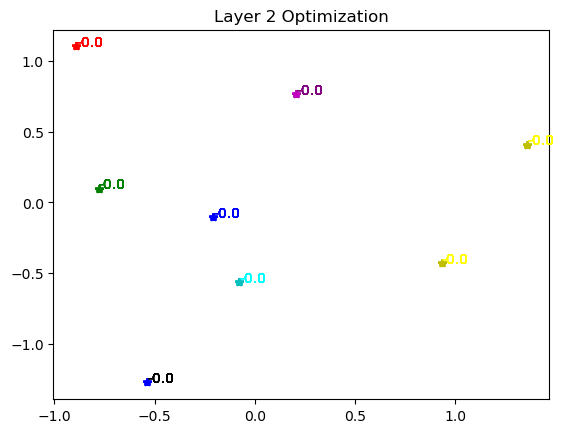

In [24]:
color_markers = ['y*', 'b*', 'g*', 'r*', 'c*', 'b*', 'm*']
color_names = ["yellow", "blue", "green", "red", "cyan", "black", 'purple']
counter = 0
color_index = 0

for coordinates in layer2_weights:
    if (counter % 10) == 0 and counter != 0:
        if color_index >= len(color_markers) - 1:
            color_index = 0
        else:
            color_index += 1
    plt.plot(coordinates[0], coordinates[1], color_markers[color_index])
    plt.annotate(str(round(loss_values[counter][0], 2)), (coordinates[0], coordinates[1]), color=color_names[color_index])
    counter += 1

plt.title("Layer 2 Optimization") 
plt.show()


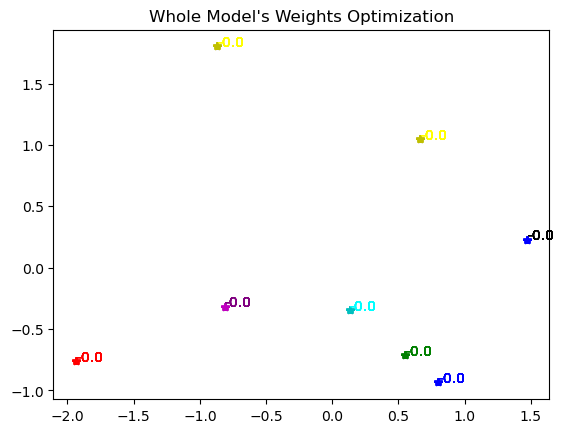

In [26]:
counter = 0
color_index = 0

for coordinates in model_weights:
    if (counter % 10) == 0 and counter != 0:
        if color_index >= len(color_markers) - 1:
            color_index = 0
        else:
            color_index += 1
    plt.plot(coordinates[0], coordinates[1], color_markers[color_index])
    plt.annotate(str(round(loss_values[counter][0], 2)), (coordinates[0], coordinates[1]), color=color_names[color_index])
    counter += 1

plt.title("Whole Model's Weights Optimization")
plt.show()
